# Analyzing HSPCs with the TemporalProblem

In this tutorial, we show how to use the TemporalProblem to analyze the trajectory of HSPC cells.



## Description of the dataset

The dataset is an extraction of the *Open Problems - Multimodal Single-Cell Integration* NeurIPS competition 2022. 

Cell type annotation was done based on *only* gene expression. Moreover, the annotation is very coarse, resulting in 

- MasP = Mast Cell Progenitor
- MkP = Megakaryocyte Progenitor
- NeuP = Neutrophil Progenitor
- MoP = Monocyte Progenitor
- EryP = Erythrocyte Progenitor
- HSC = Hematopoietic Stem Cell
- BP = B-Cell Progenitor

ATAC-seq peak counts were transformed with `TF-IDF` (`log(TF) * log(IDF)`).

## Importing packages and loading the data

In [1]:
import numpy as np
import scanpy as sc
from sklearn.preprocessing import StandardScaler

import moscot as mt
from moscot.problems.time import TemporalProblem
from moscot.datasets import hspc
import moscot.plotting as mpl

In [2]:
sc.logging.print_header()
print(f"moscot=={mt.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
moscot==0.1


In [3]:
adata = hspc()
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

We first check which time points are present in our dataset.

In [4]:
adata.obs["day"].unique()

array([2, 3, 4, 7])

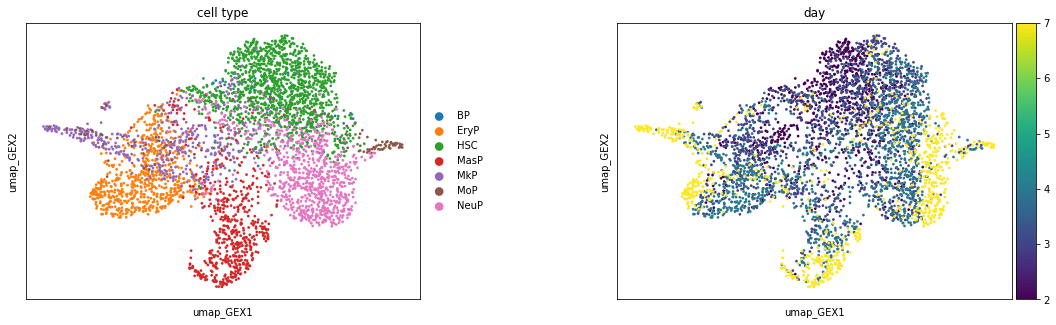

In [5]:
sc.pl.scatter(adata, basis="umap_GEX", color=["cell_type", "day"])

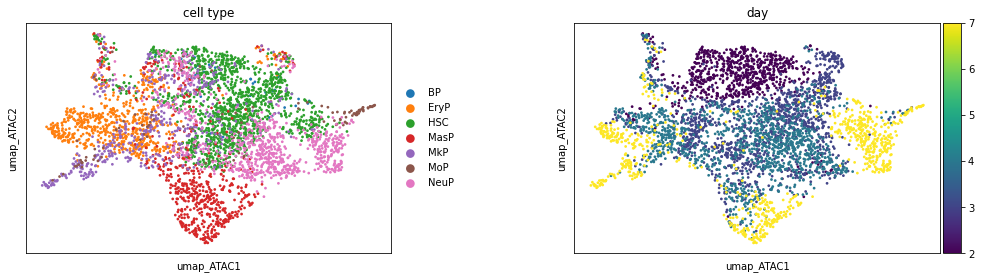

In [6]:
sc.pl.scatter(adata, basis="umap_ATAC", color=["cell_type", "day"])

As we want to leverage information from both modalities, we need to find a shared space of GEX and ATAC. There are different ways to obtain this, e.g. via scvi-tools models (https://scvi-tools.org/). Here, we simply concatenate the PCA-reduced GEX space and the LSI-reduced ATAC space.

As we want both modalities to have a comparable influence on the transport map, we need to make sure that the total variances are comparable.

In [7]:
np.var(adata.obsm["X_lsi"]), np.var(adata.obsm["X_pca"])

(1.0000002, 39.049347)

While the LSI space was standard-normalized in the course of preprocessing, this does not hold for PCA space. Hence, we standard-normalize the PCA embedding.

In [8]:
adata.obsm["X_pca_scaled"] = StandardScaler().fit_transform(adata.obsm["X_pca"])

In [9]:
#adata.obsm["X_shared"] = np.concatenate((adata.obsm["X_pca_scaled"], adata.obsm["X_lsi"]), axis=1)
adata.obsm["X_shared"] = sc.pp.pca(np.concatenate((adata.obsm["X_pca_scaled"], adata.obsm["X_lsi"]), axis=1), n_comps=30)

In [10]:
tp = TemporalProblem(adata)
tp = tp.score_genes_for_marginals(gene_set_proliferation="human", gene_set_apoptosis="human")
tp = tp.prepare(time_key="day", joint_attr="X_shared")

/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


We investigate the proliferation and apoptosis markers on the UMAP. Proliferation markers are much stronger than apoptosis markers, which can be seen from the range of the scores. This is to be expected as we are in a developmental setting.

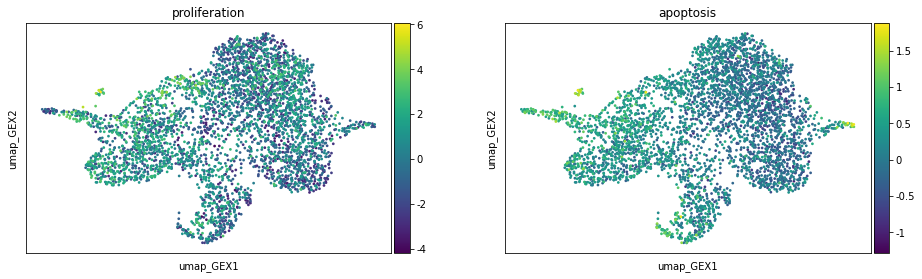

In [11]:
sc.pl.scatter(adata, basis="umap_GEX", color=["proliferation", "apoptosis"])

Now we can solve the problem. We set `epsilon` to be relatively small to get a sparse mapping between cells. Although we have a prior estimate of proliferation score of the cells, we still allow for adjustments of these prior estimates by setting `tau_a` to `0.99`. `tau_b` is chosen to be `0.999` as we don't expect many cells to die in this developmental setting. Nevertheless, we don't want to be in the fully balanced case to reduce the influence of possible outliers. `scale_cost` is set to `mean`, which simply means that we normalize the entries of the cost matrix by its mean, to stabilize training.

In [12]:
tp = tp.solve(epsilon=1e-3, tau_a=0.99, tau_b=0.999, scale_cost="mean")

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1235)].             
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1235, 1201)].            
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1201, 798)].             


## Interpreting the solutions of the Optimal Transport problems

We can compare the posterior growth rates with the prior growth rates to see the influence of the unbalancedness parameters `tau_a` and `tau_b`. Note that setting `tau_a = tau_b = 1` would result in posterior growth rates being equal to prior growth rates.

In [13]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates
adata.obs["posterior_growth_rates"] = tp.posterior_growth_rates

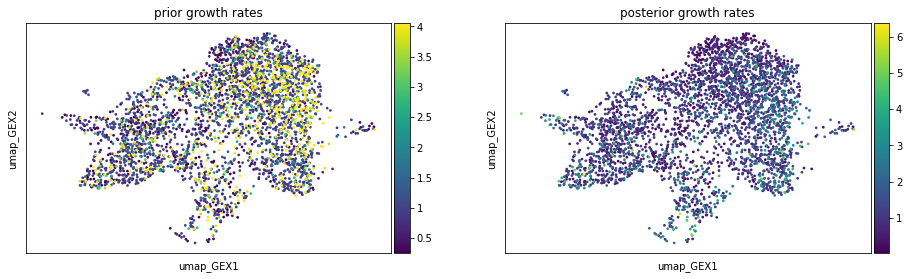

In [14]:
sc.pl.scatter(adata, basis="umap_GEX", color=["prior_growth_rates", "posterior_growth_rates"])

To learn more about the influence of each single cell to the resulting coupling, we plot the "cell costs" in the source, and target distribution, respectively. High values indicate that a certain cell is unlikely to have a descendant or ancestor, respectively. One should consider removing them and rerunning the algorithm.

In [15]:
adata.obs["cell_costs_source"] = tp.cell_costs_source
adata.obs["cell_costs_target"] = tp.cell_costs_target

We can see that there are a few cells which influence the coupling more strongly than others, but the extend is still moderate. So we continue without removing them. 

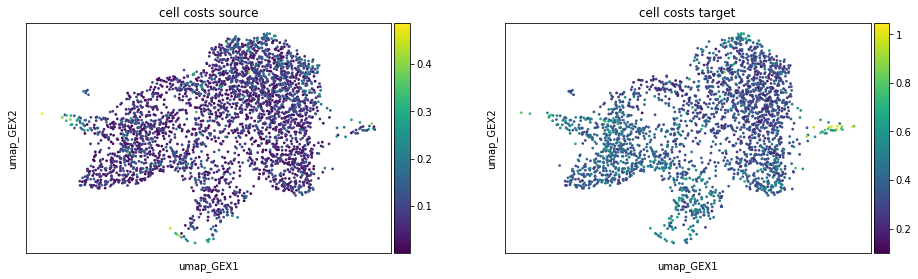

In [16]:
sc.pl.scatter(adata, basis="umap_GEX", color= ["cell_costs_source", "cell_costs_target"])

We can now investigate which cell types are mapped where. 
We start looking for descendants of cells at time point 4, which will be found in time point 7.

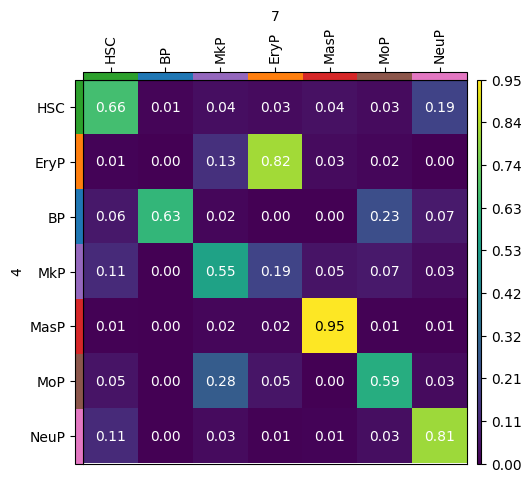

In [17]:
ct_desc = tp.cell_transition(4, 7, "cell_type", "cell_type", forward=True)
mpl.cell_transition(tp, dpi=100, fontsize=10)

The transition matrix shows where cell types at time point 4 (corresponding to the rows) are mapped in time point 7 (corresponding to the columns), hence, the rows sum up to 1. 

We find that HSC cells are mainly mapped to HCS cells, while a considerable number is also mapped to NeuP cells. In contrast, MasP cells are mapped to MasP cells.

Similarly, we can see which cell types evolve from where. Therefore, we set the parameter `forward` to `False`. 

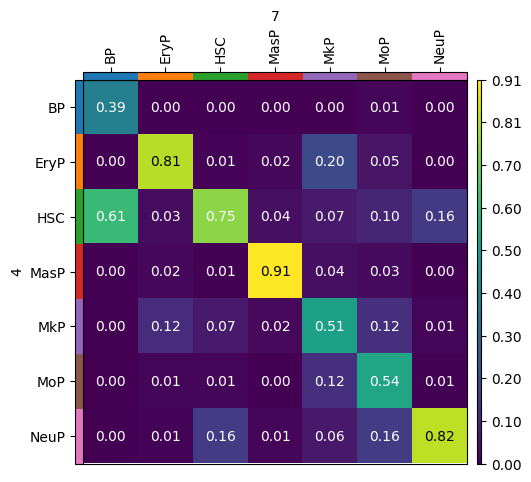

In [18]:
ct_desc = tp.cell_transition(4, 7, "cell_type", "cell_type", forward=False)
mpl.cell_transition(tp, dpi=100, fontsize=10)

Now, the columns sum up to 1, as for each cell type in a certain column, the rows indicate where the cells come from. For example, BP cells are derived from BP cells in 39/100 cases, while 61 out of 100 cells are derived from HSC cells. Similarly, most MasP cells at time point 7 were categorized as MasP cells at time point 4, while a few (4/100) were still HSC cells. 

We can also visualize ancestors and descendants on the UMAP by using the `pull` and `push` function, respectively. We start with descendants of all cells at time point 4.

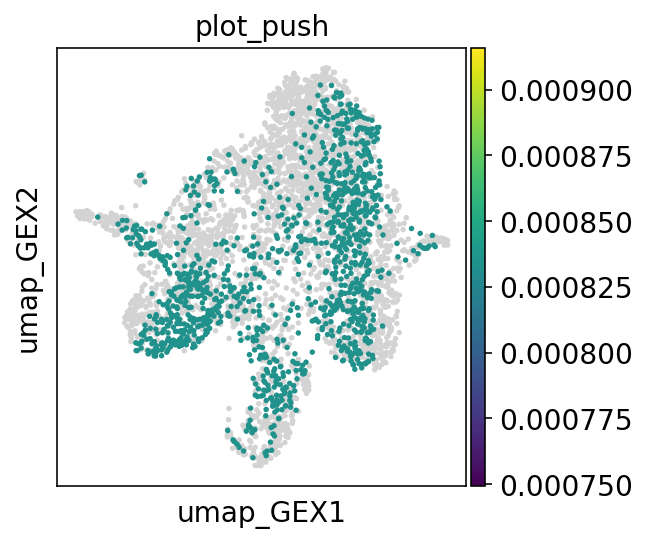

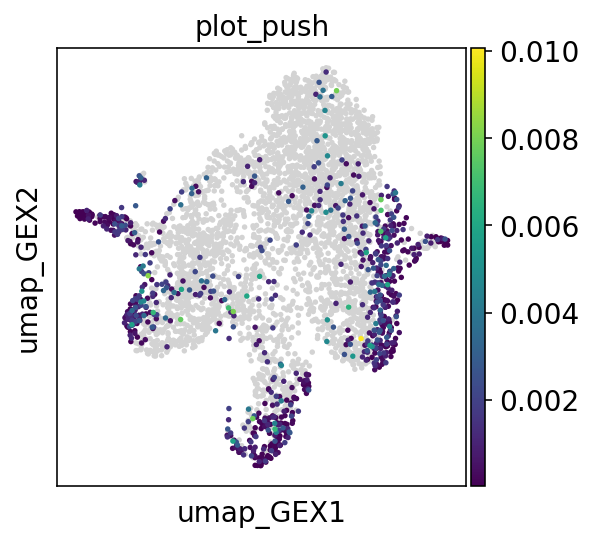

In [19]:
tp.push(start=4, end=7)
mpl.push(tp, time_points=[4], basis="umap_GEX")
mpl.push(tp, time_points=[7], basis="umap_GEX")

We can also visualize the descendants of a certain subgroup. For example, we can visualize where MasP cells are mapped to.

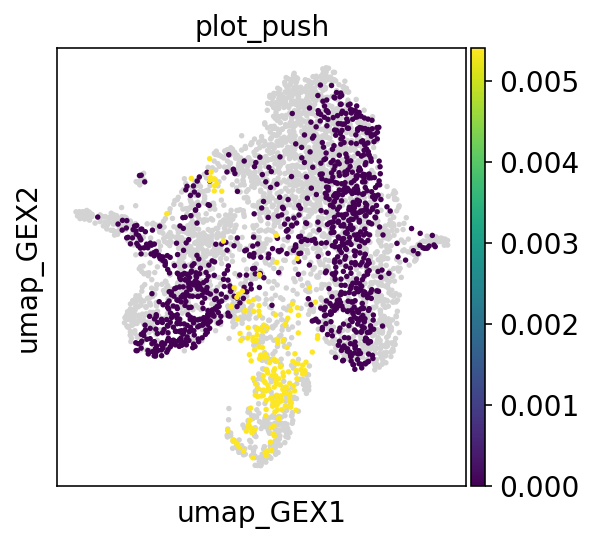

In [20]:
tp.push(start=4, end=7, data="cell_type", subset="MasP")
mpl.push(tp, time_points=[4], basis="umap_GEX")

The plot above colorizes all cells at time point 4, while the colors indicates the assigned mass. Effectively, we will only consider MasP cells, which are colorized in yellow, while cells at time point 4 belonging to any of the other cell types are colorized in purple. Now, we consider the descendants of the MasP cells at time point 4.

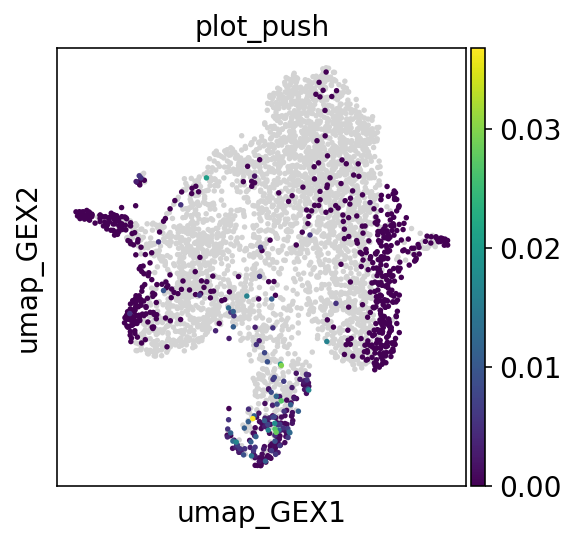

In [21]:
mpl.push(tp, time_points=[7], basis="umap_GEX")

Similarly, we can visualize ancestors of BP cells measured at time point 7, which we look for in time point 4.

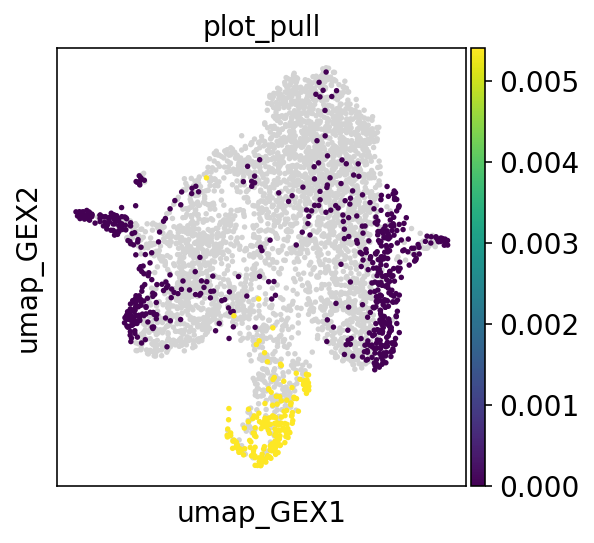

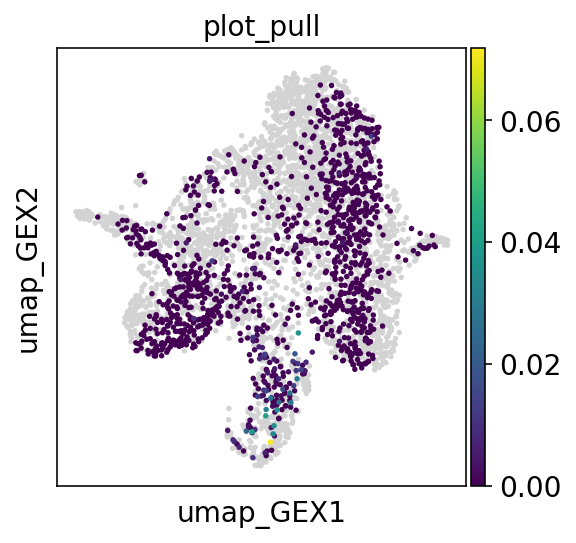

In [22]:
tp.pull(start=4, end=7, data="cell_type", subset="MasP")
mpl.pull(tp, time_points=[7], basis="umap_GEX")
mpl.pull(tp, time_points=[4], basis="umap_GEX")

To get an idea of the dynamics across all time points, we can visualize the cell type evolution with a Sankey diagram.

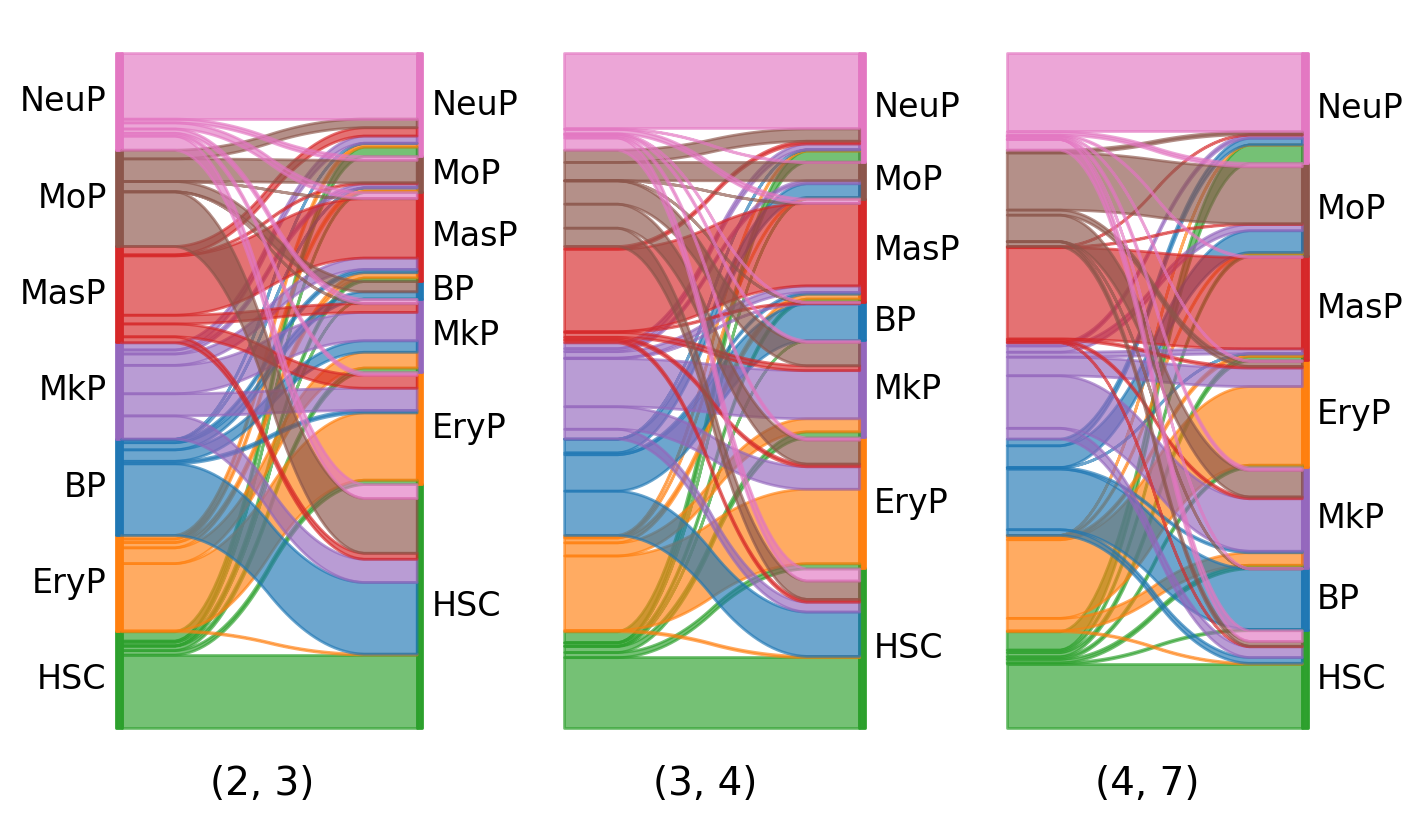

In [23]:
tp.sankey(source=2, target=7, source_groups="cell_type", target_groups="cell_type")
mpl.sankey(tp, dpi=100, figsize=(7,4))

## Assessing the quality of the transport maps

We can assess the quality of the transport map between two non-consecutive time points by interpolation.
Here, we approximate the cell distribution at time point 3 by computing the OT coupling between time point 2 and time point 4. As we haven't computed the coupling between time point 3 and time point 7 yet, we need to use the `add_problem` method.

In [24]:
tp_to_add = TemporalProblem(adata)
tp_to_add = tp_to_add.score_genes_for_marginals(gene_set_proliferation="human", gene_set_apoptosis="human")
tp_to_add = tp_to_add.prepare("day", policy="explicit", subset=[(2,4)], joint_attr="X_shared")
tp_to_add = tp_to_add.solve(epsilon=1e-3, tau_a=0.99, tau_b=0.999, scale_cost="mean")

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1201)].             


/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [25]:
tp = tp.add_problem(key=(2,4), problem=tp_to_add[(2,4)])

Thus, we can now compute the interpolated distance. Computing distances between distributions implies solving Optimal Transport problems, hence we can pass parameters specifying the OT solution. Again, we try to set epsilon as small as possible. Note that we do not want to scale the cost this time as we are interested in the value of the distance and not primarily in the coupling as before.

In [26]:
eps_interpolation=5e-1

In [27]:
interpolated_distance = tp.compute_interpolated_distance(start=2, intermediate=3, end=4, epsilon=eps_interpolation)
print(f"The interpolated distance is {interpolated_distance:.2f}.")

The interpolated distance is 33.04.


To get an idea of how how good the result is (the smaller, the better), we compute distances we can compare the result to. Therefore, we can consider the distances between the distributions at time point 2 and time point 3, and time point 3 and time point 4.

In [28]:
time_point_distance = tp.compute_time_point_distances(start=2, intermediate=3, end=4, epsilon=eps_interpolation)
print(f"The distance between the cell distribution at time point 2 and 3 is {time_point_distance[0]:.2f}, and between 3 and 4 it is {time_point_distance[1]:.2f}.")

The distance between the cell distribution at time point 2 and 3 is 39.28, and between 3 and 4 it is 40.22.


We can see that the distances of cell distributions between time points are clearly higher than the distance between the interpolated and the ground truth cell distribution. 

## Finding new subclusters 

So far we only considered the cell type annotations to perform trajectory inference.
The `TemporalProblem` is helpful to detect trajectories of subpopulations. Therefore, we subcluster the HSC cells.

As mentioned above, the cell type annotation is based on gene expression only, and hence does not take the ATAC modality into account, while our computed transport maps leverage both modalities.
For subclustering we will now also use both modalities. Thus, we compute the neighbors based on our joint embedding.

In [29]:
sc.pp.neighbors(adata, use_rep="X_shared")

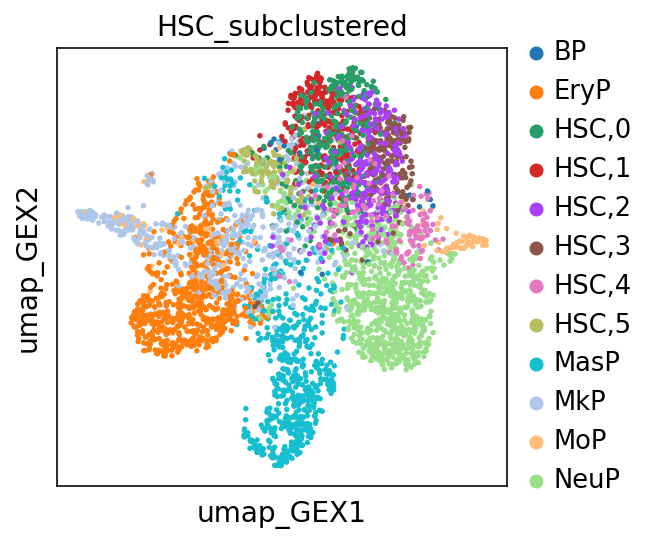

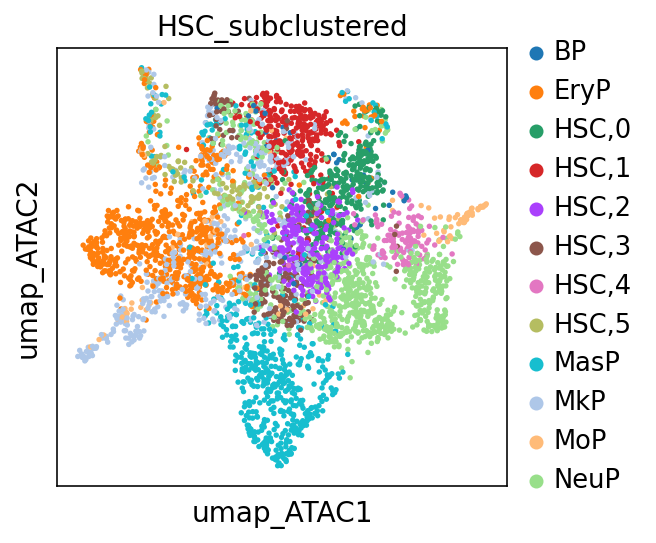

In [30]:
new_key = "HSC_subclustered"
sc.tl.leiden(adata, restrict_to=("cell_type", ["HSC"]), key_added=new_key, resolution=0.5)
sc.pl.embedding(adata, color=new_key, basis="umap_GEX")
sc.pl.embedding(adata, color=new_key, basis="umap_ATAC")

Now, we can consider the transitions between the subclusters.
Therefore, we consider where the subclusters of HSCs at time point 3 are mapped to in time point 4.

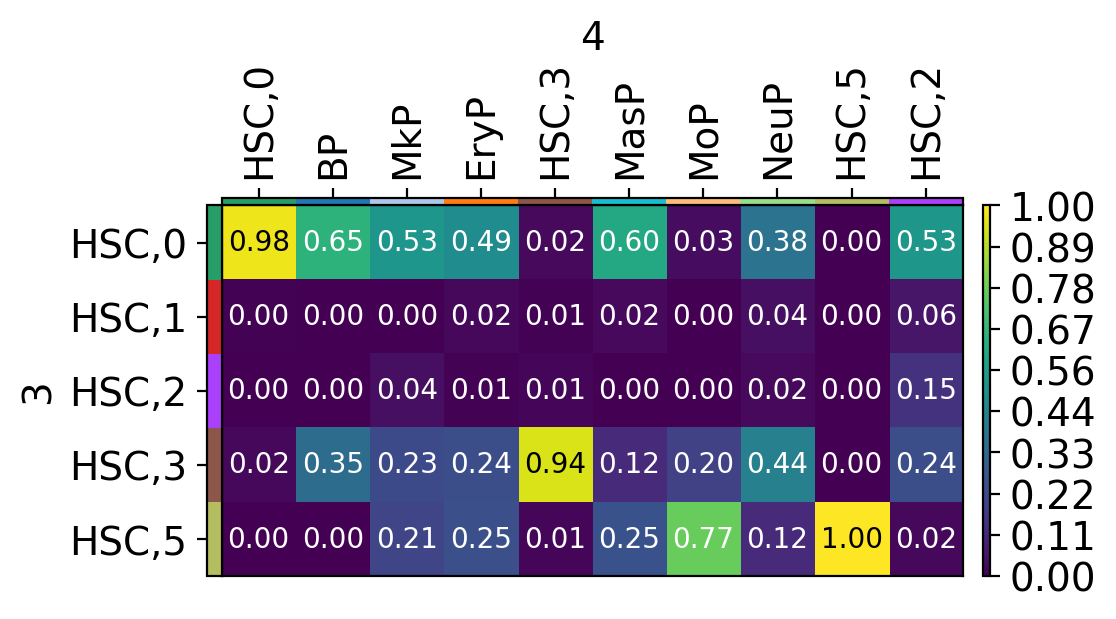

In [31]:
tp.cell_transition(3, 4, source_groups={new_key: ["HSC,0", "HSC,1", "HSC,2", "HSC,3", "HSC,4", "HSC,5"]}, target_groups=new_key, forward=False)
mpl.cell_transition(tp, dpi=100, fontsize=10)

We can see that MoP cells mainly evolve from the HSC,5 subcluster while BP cells have progenitors in both HSC,0 and HSC,3. HSC,2 seems to be a subcluster succeeding the HSC,0 subcluster.